In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime

import random 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, plot_confusion_matrix, roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from collections import Counter


In [3]:
# Load data
file = open('../data/final_fed_data.pickle', 'rb')
data = pd.read_pickle(file)
file.close()

print(data.shape)
data.tail()

(247, 78)


,word_count,next_rate,0,1,2,3,4,5,6,7,...,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff,next_decision
next_meeting,,,,,,,,,,,,,,,,,,,,,
2021-01-27,3581.0,0.0,0.0,0.000000,0.0,0.000000,0.192184,0.0,0.000000,0.802176,...,0.802493,0.000000,0.000000,0.802493,0.000000,0.000000,-0.052646,0.000000,0.000000,2.0
2021-03-17,3216.0,0.0,0.0,0.000000,0.0,0.000000,0.185558,0.0,0.005331,0.803908,...,1.319339,0.000000,0.000000,1.319339,0.000000,0.000000,0.516847,0.000000,0.000000,2.0
2021-04-28,2298.5,0.0,0.0,0.000000,0.0,0.000000,0.191281,0.0,0.000000,0.803392,...,1.286692,0.000000,0.000000,1.286692,0.000000,0.000000,-0.032647,0.000000,0.000000,2.0
2021-06-16,2939.0,0.0,0.0,0.007824,0.0,0.000000,0.204571,0.0,0.000000,0.782446,...,4.239942,2.825180,-0.423777,4.239942,2.825180,-0.423777,2.953250,2.825180,-0.423777,2.0
2021-07-28,2716.5,0.0,0.0,0.000000,0.0,0.007714,0.185160,0.0,0.000000,0.801772,...,4.749861,3.335099,-0.500265,4.749861,3.335099,-0.500265,0.509919,0.509919,-0.076488,2.0


In [4]:
# fed calendar
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')
fomc_cal = pd.read_pickle(file)
file.close()

print(fomc_cal.shape)
fomc_cal.tail()

(396, 8)


,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision,ChairPerson,RateChanged
date,,,,,,,,
2021-06-16,False,True,False,0.0,0.0,0,NaN,0
2021-07-28,False,False,False,0.0,0.0,0,NaN,0
2021-09-22,False,True,False,0.0,0.0,0,NaN,0
2021-11-03,False,False,False,0.0,0.0,0,NaN,0
2021-12-15,False,True,False,0.0,0.0,0,NaN,0


In [5]:
# model features
feature_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                  'Rsales_diff_prev', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff',
                  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17
                  ]

X = data.dropna(subset = ['next_decision'])
X = X[feature_columns]
X = X.dropna(axis='columns')

In [6]:
feature_list = list(X.columns)

X = np.array(X)
y = np.array(data['next_decision'])

In [7]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = random.randint(0,1000), shuffle = False)

Class=2, n=134 (68.020%)
Class=3, n=31 (15.736%)
Class=1, n=32 (16.244%)


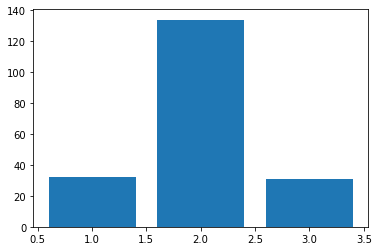

In [8]:
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [12]:
# oversample using SMOTE
# reference: https://machinelearningmastery.com/multi-class-imbalanced-classification/
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

ImportError: cannot import name '_euclidean_distances' from 'sklearn.metrics.pairwise' (/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py)

In [11]:
#pip install imblearn

     |████████████████████████████████| 199 kB 1.7 MB/s eta 0:00:01
  Using cached scikit_learn-1.0.2-cp39-cp39-macosx_10_13_x86_64.whl (8.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import time
import logging

# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

# Use Stratified KFold Cross Validation
n_fold = 7
kfold = StratifiedKFold(n_splits=n_fold)
kfold
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(x_train, y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(x_train)
    pred_test = best_estimator.predict(x_test)

    acc, f1 = metric(y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, x_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, x_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, x_train, y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, x_train, y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, x_test, y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, x_test, y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()


# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_split': [5],
              'min_samples_leaf': [10],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_


## Final Model

In [ ]:
rf_model = RandomForestClassifier(bootstrap = False, criterion = 'gini', 
                                  max_depth = None, max_features = 8, min_samples_leaf = 10, 
                                  min_samples_split = 5, n_estimators = 357)


rf_model = rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)

# accuracy
scores = rf_model.score(x_test, y_test)
print('Accuracy: ', scores)

# roc 
print('ROC score: ', roc_auc_score(y_test, rf_model.predict_proba(x_test), multi_class='ovr'))

## Visualize Predictions

In [ ]:
plt.plot(y_test, 'o', color='orange', label = "Actual")
plt.plot(rf_predictions,  'x', color='blue', label = "Prediction")
plt.title('1-Step Ahead')
plt.legend()

In [ ]:
### Confusion Matrix ###
class_names = ['Lower', 'Hold', 'Raise']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Confusion Matrix", fontsize=20)

plot_confusion_matrix(rf_model, x_train, y_train, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Train Data: Actual Count")
ax1.grid(False)

plot_confusion_matrix(rf_model, x_train, y_train, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize='all', ax=ax2)
ax2.set_title=("Train Data: Normalized")
ax2.grid(False)

plot_confusion_matrix(rf_model, x_test, y_test, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize=None, ax=ax3)
ax3.set_title=("Test Data: Actual Count")
ax3.grid(False)

plot_confusion_matrix(rf_model, x_test, y_test, display_labels=class_names, 
                      cmap=plt.cm.Blues, normalize='all', ax=ax4)
ax4.set_title("Test Data: Normalized")
ax4.grid(False)

plt.tight_layout(pad=3.0)
plt.show()
    

## Get numerical feature importances

In [ ]:
importances = list(rf_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


In [ ]:
#plt.plot(data.index, data.Inertia_diff, label = 'Inertia Rule')
#plt.plot(data.index, np.log(data.PMI_value), label = 'PMI')

plt.figure(figsize=(10, 6), dpi=80)

plt.plot(data.index, data.next_rate, 'o', alpha = 0.5, label = 'Next Rate Decision')
plt.plot(data.index, data[6], 'x', label = 'Topic 6')
plt.plot(data.index, data[5], 'x', label = 'Topic 5')
plt.legend()

In [ ]:
display(data)

## Save Model

In [ ]:
# save the model to disk
pickle.dump(rf_model, open('../data/final_fed_model', 'wb'))

## Multi-Step Predictions

In [ ]:
feature_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev',
                   'GDPPOT_diff_year', 'PCE_diff_prev', 'PCE_diff_year',
                   'CPI_diff_prev', 'CPI_diff_year', 'Unemp_value',
                   'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_value',
                   'Employ_diff_prev', 'Employ_diff_year', 'PMI_value',
                   'PMI_diff_prev', 'PMI_diff_year', 'Rsales_diff_prev',
                   'Hsales_diff_prev', 'Hsales_diff_year', 'Taylor-Rate',
                   'Balanced-Rate', 'Inertia-Rate',  'Taylor_diff',
                   'Balanced_diff', 'Inertia_diff', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

future_pred = []

def multi_step_pred(y_col, n_steps):
    for step in n_steps:
        col_name = str(y_col) + '_' + str(step)
        data[col_name] = data['RateDecision'].shift(step)
        df = data.dropna(subset = [col_name])

        X = df[feature_columns]
        X = X.dropna(axis='columns')
        feature_list = list(X.columns)
        X = np.array(X)
        y = np.array(df[col_name])

        # set random seed
        random.seed(42)
        np.random.seed(42)
        rand_seed = 42

        # split
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = random.randint(0,1000), shuffle = False)
        x_train, y_train = oversample.fit_resample(x_train, y_train)

        rf_model = RandomForestClassifier(bootstrap = False, criterion = 'gini', 
                                      max_depth = None, max_features = 8, min_samples_leaf = 10, 
                                      min_samples_split = 5, n_estimators = 500)

        rf_model = rf_model.fit(x_train, y_train)
        rf_predictions = rf_model.predict(x_test)

        # performance
        scores = rf_model.score(x_test, y_test)
        print(str(step) + '-Ahead Accuracy: ', scores)
        print(str(step) + '-Ahead ROC score: ', roc_auc_score(y_test, rf_model.predict_proba(x_test), multi_class='ovr'))

        # plot
        plt.plot(y_test, 'o', color='orange', label = "Actual")
        plt.plot(rf_predictions,  'x', color='blue', label = "Prediction")
        plt.title(str(step) + '-Ahead Prediction')
        plt.legend()
        plt.show()

        future_x = data[data.index == '2021-07-28']
        future_x = future_x.dropna(axis = 'columns')
        future_x = future_x[feature_columns]

        prediction = rf_model.predict(np.array(future_x))
        prediction = int(prediction)
        
        future_pred.append(prediction)
       
    return future_pred
    

In [ ]:
n_steps = list(range(1,13))
multi_step_pred('RateDecision', n_steps)

In [ ]:
future_pred = pd.Series(future_pred)
future_pred

In [ ]:
ffr_data = data['RateDecision']
ffr_data = ffr_data.append((future_predictions))
ffr_data

## Save Output

In [ ]:
ffr_data.to_csv('../data/fed_funds_predictions.csv', index=True)